In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import shap
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
# Define specific time points for interpolation
interp_time_points = [1, 2, 3]
num_interp_pts = len(interp_time_points)
n_outer_folds = 10
n_inner_folds = 2
n_trials = 50
# ----------------------------------------------------------------------------------------
# Load data
# ----------------------------------------------------------------------------------------
file_path_form = 'mp_dataset_processed_no_dupes.xlsx'
file_path_time = 'mp_dataset_processed_time_release_only.xlsx'
formulation_df = pd.read_excel(file_path_form, engine='openpyxl')
release_df = pd.read_excel(file_path_time, engine='openpyxl')
# Encode categorical
unique_values_emulsion = formulation_df['Formulation Method'].unique()
mapping = {v: i for i, v in enumerate(unique_values_emulsion)}
formulation_df['Formulation Method Encoded'] = formulation_df['Formulation Method'].map(mapping)
formulation_df.drop(columns=['Formulation Method', 'Drug SMILES'], inplace=True)
# ----------------------
# Interpolation at specific time points (1, 2, 3)
# ----------------------
interpolated_dfs = []
for formulation, g in release_df.groupby('Formulation Index'):
    g = g.sort_values('Time')
    # Interpolate at fixed time points
    interp_release = np.interp(interp_time_points, g['Time'], g['Release'])
    interpolated_dfs.append(pd.DataFrame({
        'Formulation Index': formulation,
        'Time_interp': interp_time_points,
        'Interpolated Release': interp_release
    }))
interp_df = pd.concat(interpolated_dfs, ignore_index=True)

In [54]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ----------------------------------------------------------------------------------------
# Prepare X and y
# ----------------------------------------------------------------------------------------
X = formulation_df.drop(columns=['Formulation Index']).to_numpy()
y = interp_df.pivot(index='Formulation Index', columns='Time_interp', values='Interpolated Release').to_numpy()
# Shape: (n_formulations, 3)

class XGBModel:
    def __init__(self, **params):
        base_model = XGBRegressor(
            **params,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror"
        )
        self.model = MultiOutputRegressor(base_model)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse

# ----------------------------------------------------------------------------------------
# Nested CV setup
# ----------------------------------------------------------------------------------------
outer_kf = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)
inner_kf = KFold(n_splits=n_inner_folds, shuffle=True, random_state=42)

# ----------------------------------------------------------------------------------------
# Storage
# ----------------------------------------------------------------------------------------
stored_best_models = []
stored_best_preds = []
stored_test_targets = []
stored_best_rmse = []
stored_best_mse = []
stored_corr = []
stored_pval = []
all_outer_train_loss_curves_best = []
stored_shap_values = []
stored_shap_test_sets = []

rmse_per_timepoint = {t: [] for t in interp_time_points}
corr_per_timepoint = {t: [] for t in interp_time_points}
pval_per_timepoint = {t: [] for t in interp_time_points}

# ----------------------------------------------------------------------------------------
# Outer CV loop
# ----------------------------------------------------------------------------------------
for outer_fold, (train_idx, test_idx) in enumerate(outer_kf.split(X, y)):
    print(f"\nOuter Fold {outer_fold + 1}")
    X_train_val, y_train_val = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    stored_test_targets.append(y_test)

    # ----------------------------------------------------------------------------------------
    # Optuna objective for inner CV
    # ----------------------------------------------------------------------------------------
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        }
        val_losses = []
        for inner_train_idx, inner_val_idx in inner_kf.split(X_train_val, y_train_val):
            X_tr, X_val = X_train_val[inner_train_idx], X_train_val[inner_val_idx]
            y_tr, y_val = y_train_val[inner_train_idx], y_train_val[inner_val_idx]

            model = XGBModel(**params)
            model.fit(X_tr, y_tr)
            val_losses.append(model.evaluate(X_val, y_val))

        return np.mean(val_losses)

    # ----------------------------------------------------------------------------------------
    # Run Optuna study
    # ----------------------------------------------------------------------------------------
    tpe_sampler = TPESampler(seed=42)
    study = optuna.create_study(direction="minimize", sampler=tpe_sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_params = study.best_params
    print("Best params:", best_params)

    # ----------------------------------------------------------------------------------------
    # Train best model on full training data
    # ----------------------------------------------------------------------------------------
    best_model = XGBModel(**best_params)
    best_model.fit(X_train_val, y_train_val)
    preds_best = best_model.predict(X_test)

    # ----------------------------------------------------------------------------------------
    # Calculate and store SHAP values on the outer test set
    # ----------------------------------------------------------------------------------------
    print("Calculating SHAP values for the outer test set...")
    np.random.seed(42)

    shap_values_per_output = []

    for i, estimator in enumerate(best_model.model.estimators_):
        explainer = shap.TreeExplainer(estimator)
        shap_vals = explainer.shap_values(X_test)
        shap_values_per_output.append(shap_vals)

    stored_shap_values.append(shap_values_per_output)
    stored_shap_test_sets.append(X_test)


    # ----------------------------------------------------------------------------------------
    # Compute metrics
    # ----------------------------------------------------------------------------------------
    mse_best = mean_squared_error(y_test, preds_best)
    rmse_best = np.sqrt(mse_best)

    
    # Flatten for correlation
    corr_best, pval_best = pearsonr(y_test.flatten(), preds_best.flatten())

    # Per-timepoint metrics
    for i, t in enumerate(interp_time_points):
        rmse_t = np.sqrt(mean_squared_error(y_test[:, i], preds_best[:, i]))
        corr_t, pval_t = pearsonr(y_test[:, i], preds_best[:, i])                  
        rmse_per_timepoint[t].append(rmse_t)
        corr_per_timepoint[t].append(corr_t)
        pval_per_timepoint[t].append(pval_t)
        
        print(f"  Time {t}h: RMSE={rmse_t:.4f}, Corr={corr_t:.4f}, Adj R2={adj_r2_t:.4f}")

    # ----------------------------------------------------------------------------------------
    # Store results
    # ----------------------------------------------------------------------------------------
    stored_best_models.append(best_model)
    stored_best_preds.append(preds_best)
    stored_best_mse.append(mse_best)
    stored_best_rmse.append(rmse_best)
    stored_corr.append(corr_best)
    stored_pval.append(pval_best)
    all_outer_train_loss_curves_best.append([mse_best])


# ----------------------------------------------------------------------------------------
# Summary
# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
# Summary - per timepoint
# ----------------------------------------------------------------------------------------
print("\n" + "="*70)
print("SUMMARY ACROSS ALL FOLDS (per timepoint)")
print("="*70)
print(f"{'Time':<10} {'RMSE':<20} {'Correlation':<25} {'Adj R²':<20}")
print("-"*70)
for t in interp_time_points:
    rmse_mean, rmse_std = np.mean(rmse_per_timepoint[t]), np.std(rmse_per_timepoint[t])
    corr_mean, corr_std = np.mean(corr_per_timepoint[t]), np.std(corr_per_timepoint[t])
    pval_median = np.median(pval_per_timepoint[t])
    print(f"{t}h{'':<8} {rmse_mean:.4f} ± {rmse_std:.4f}    {corr_mean:.4f} ± {corr_std:.4f} (p={pval_median:.2e})")


Outer Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'max_depth': 6, 'learning_rate': 0.0753017469084618, 'n_estimators': 226, 'subsample': 0.5030345194238098, 'colsample_bytree': 0.5913101976811079, 'gamma': 0.012755165152574043, 'reg_alpha': 0.4122733769325751, 'reg_lambda': 0.6290267126356788}
Calculating SHAP values for the outer test set...
  Time 24h: RMSE=0.1496, Corr=0.6498, Adj R2=0.1221
  Time 48h: RMSE=0.1693, Corr=0.6755, Adj R2=0.1221
  Time 72h: RMSE=0.1773, Corr=0.7148, Adj R2=0.1221

Outer Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'max_depth': 13, 'learning_rate': 0.17848471009893402, 'n_estimators': 187, 'subsample': 0.9348658639034384, 'colsample_bytree': 0.7732508373200901, 'gamma': 0.005903125831769838, 'reg_alpha': 0.8789504884750577, 'reg_lambda': 0.752768132632663}
Calculating SHAP values for the outer test set...
  Time 24h: RMSE=0.1024, Corr=0.7375, Adj R2=0.1221
  Time 48h: RMSE=0.1403, Corr=0.7177, Adj R2=0.1221
  Time 72h: RMSE=0.1683, Corr=0.6865, Adj R2=0.1221

Outer Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'max_depth': 10, 'learning_rate': 0.2597961683861477, 'n_estimators': 101, 'subsample': 0.7345333714668801, 'colsample_bytree': 0.7740106166754568, 'gamma': 0.008554418542379844, 'reg_alpha': 0.5619379761711434, 'reg_lambda': 0.7435774757558886}
Calculating SHAP values for the outer test set...
  Time 24h: RMSE=0.1944, Corr=0.4045, Adj R2=0.1221
  Time 48h: RMSE=0.1929, Corr=0.5337, Adj R2=0.1221
  Time 72h: RMSE=0.1947, Corr=0.6258, Adj R2=0.1221

Outer Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'max_depth': 16, 'learning_rate': 0.22466428994932008, 'n_estimators': 153, 'subsample': 0.8088249647189678, 'colsample_bytree': 0.8895164161417117, 'gamma': 0.0038369408102559427, 'reg_alpha': 0.8381987274912102, 'reg_lambda': 0.8836313445148407}
Calculating SHAP values for the outer test set...
  Time 24h: RMSE=0.1476, Corr=0.5582, Adj R2=0.1221
  Time 48h: RMSE=0.1602, Corr=0.6200, Adj R2=0.1221
  Time 72h: RMSE=0.1653, Corr=0.6681, Adj R2=0.1221

Outer Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'max_depth': 17, 'learning_rate': 0.24766969779467396, 'n_estimators': 278, 'subsample': 0.5455283570033114, 'colsample_bytree': 0.7688104081102793, 'gamma': 0.006080480446899888, 'reg_alpha': 0.5404157526768982, 'reg_lambda': 0.7866609184452235}
Calculating SHAP values for the outer test set...
  Time 24h: RMSE=0.1504, Corr=0.7245, Adj R2=0.1221
  Time 48h: RMSE=0.1887, Corr=0.5989, Adj R2=0.1221
  Time 72h: RMSE=0.1860, Corr=0.6361, Adj R2=0.1221

Outer Fold 6


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'max_depth': 10, 'learning_rate': 0.2597961683861477, 'n_estimators': 101, 'subsample': 0.7345333714668801, 'colsample_bytree': 0.7740106166754568, 'gamma': 0.008554418542379844, 'reg_alpha': 0.5619379761711434, 'reg_lambda': 0.7435774757558886}
Calculating SHAP values for the outer test set...
  Time 24h: RMSE=0.1668, Corr=0.6079, Adj R2=0.1221
  Time 48h: RMSE=0.1980, Corr=0.5838, Adj R2=0.1221
  Time 72h: RMSE=0.2164, Corr=0.5807, Adj R2=0.1221

Outer Fold 7


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'max_depth': 12, 'learning_rate': 0.14294744392999426, 'n_estimators': 170, 'subsample': 0.6343710064478558, 'colsample_bytree': 0.8222526744666474, 'gamma': 0.012421818456947946, 'reg_alpha': 0.9146700038095199, 'reg_lambda': 0.7830268014182126}
Calculating SHAP values for the outer test set...
  Time 24h: RMSE=0.0937, Corr=0.8642, Adj R2=0.1221
  Time 48h: RMSE=0.1095, Corr=0.8524, Adj R2=0.1221
  Time 72h: RMSE=0.1245, Corr=0.8312, Adj R2=0.1221

Outer Fold 8


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'max_depth': 11, 'learning_rate': 0.1863031185090387, 'n_estimators': 135, 'subsample': 0.757169894700505, 'colsample_bytree': 0.7698756543497769, 'gamma': 0.006292280394064001, 'reg_alpha': 0.4121331634561264, 'reg_lambda': 0.14425130502977024}
Calculating SHAP values for the outer test set...
  Time 24h: RMSE=0.1595, Corr=0.4983, Adj R2=0.1221
  Time 48h: RMSE=0.1697, Corr=0.6019, Adj R2=0.1221
  Time 72h: RMSE=0.1739, Corr=0.6248, Adj R2=0.1221

Outer Fold 9


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'max_depth': 10, 'learning_rate': 0.2597961683861477, 'n_estimators': 101, 'subsample': 0.7345333714668801, 'colsample_bytree': 0.7740106166754568, 'gamma': 0.008554418542379844, 'reg_alpha': 0.5619379761711434, 'reg_lambda': 0.7435774757558886}
Calculating SHAP values for the outer test set...
  Time 24h: RMSE=0.1738, Corr=0.6269, Adj R2=0.1221
  Time 48h: RMSE=0.2055, Corr=0.6525, Adj R2=0.1221
  Time 72h: RMSE=0.2192, Corr=0.7180, Adj R2=0.1221

Outer Fold 10


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'max_depth': 17, 'learning_rate': 0.2292138014554286, 'n_estimators': 207, 'subsample': 0.8135087113741349, 'colsample_bytree': 0.8499697810106054, 'gamma': 0.008554418542379844, 'reg_alpha': 0.5619379761711434, 'reg_lambda': 0.641815168097599}
Calculating SHAP values for the outer test set...
  Time 24h: RMSE=0.1462, Corr=0.6724, Adj R2=0.1221
  Time 48h: RMSE=0.1625, Corr=0.6822, Adj R2=0.1221
  Time 72h: RMSE=0.1849, Corr=0.6587, Adj R2=0.1221

SUMMARY ACROSS ALL FOLDS (per timepoint)
Time       RMSE                 Correlation               Adj R²              
----------------------------------------------------------------------
24h         0.1484 ± 0.0289    0.6344 ± 0.1230 (p=8.31e-05)
48h         0.1697 ± 0.0276    0.6518 ± 0.0842 (p=1.03e-04)
72h         0.1810 ± 0.0257    0.6745 ± 0.0660 (p=3.54e-05)


In [40]:
for i, t in enumerate(interp_time_points):
    print(f"Time {t}h: target mean={y_test[:, i].mean():.3f}, std={y_test[:, i].std():.3f}, range=[{y_test[:, i].min():.3f}, {y_test[:, i].max():.3f}]")

Time 24h: target mean=0.228, std=0.197, range=[0.001, 0.694]
Time 48h: target mean=0.290, std=0.222, range=[0.002, 0.732]
Time 72h: target mean=0.346, std=0.246, range=[0.003, 0.790]


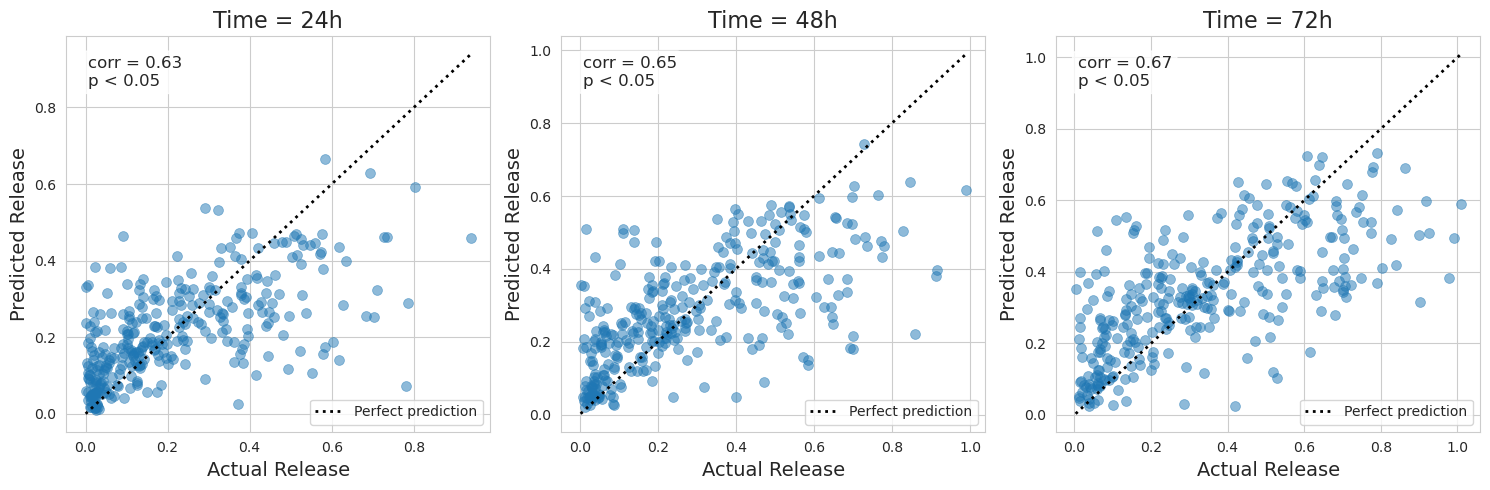

In [18]:
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

all_preds = np.vstack(stored_best_preds)
all_targets = np.vstack(stored_test_targets)

for i, t in enumerate(interp_time_points):
    ax = axes[i]
    
    # Seaborn scatter with regression line (optional)
    sns.scatterplot(x=all_targets[:, i], y=all_preds[:, i], alpha=0.5, 
                    edgecolor=None, s=50, ax=ax)
    
    # Perfect prediction line - black dotted
    lims = [min(all_targets[:, i].min(), all_preds[:, i].min()),
            max(all_targets[:, i].max(), all_preds[:, i].max())]
    ax.plot(lims, lims, 'k:', linewidth=2, label='Perfect prediction')
    
    ax.set_xlabel("Actual Release", fontsize=14)
    ax.set_ylabel("Predicted Release", fontsize=14)
    ax.set_title(f"Time = {t}h", fontsize=16)
    
    corr, pval = pearsonr(all_targets[:, i], all_preds[:, i])
    ax.text(0.05, 0.95, f"corr = {corr:.2f}\np < 0.05", 
            transform=ax.transAxes, fontsize=12, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

/tmp/ipykernel_4059577/3562228920.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(rmse_per_timepoint.values(), labels=[f"{t}h" for t in interp_time_points])


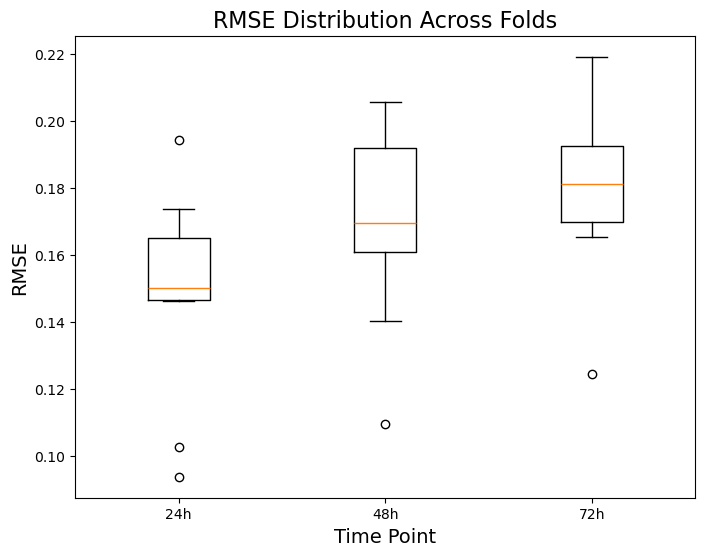

In [11]:
rmse_per_timepoint = {t: [] for t in interp_time_points}
for preds, targets in zip(stored_best_preds, stored_test_targets):
    for i, t in enumerate(interp_time_points):
        rmse_t = np.sqrt(mean_squared_error(targets[:, i], preds[:, i]))
        rmse_per_timepoint[t].append(rmse_t)

plt.figure(figsize=(8, 6))
plt.boxplot(rmse_per_timepoint.values(), labels=[f"{t}h" for t in interp_time_points])
plt.xlabel("Time Point", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("RMSE Distribution Across Folds", fontsize=16)
plt.show()

/tmp/ipykernel_4059577/4051206051.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap("coolwarm")  # red-to-blue
/tmp/ipykernel_4059577/4051206051.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_for_output_i, all_X_test, feature_names=feature_names, show=False,


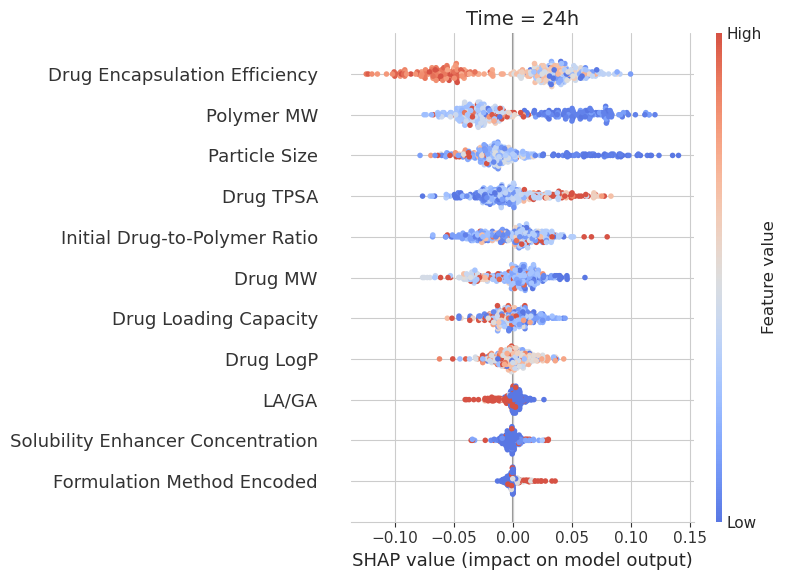

/tmp/ipykernel_4059577/4051206051.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_for_output_i, all_X_test, feature_names=feature_names, show=False,


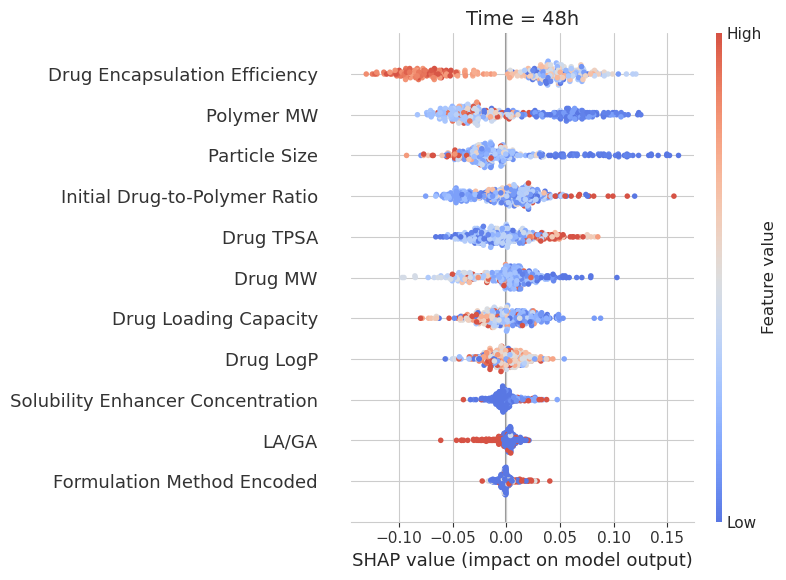

/tmp/ipykernel_4059577/4051206051.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_for_output_i, all_X_test, feature_names=feature_names, show=False,


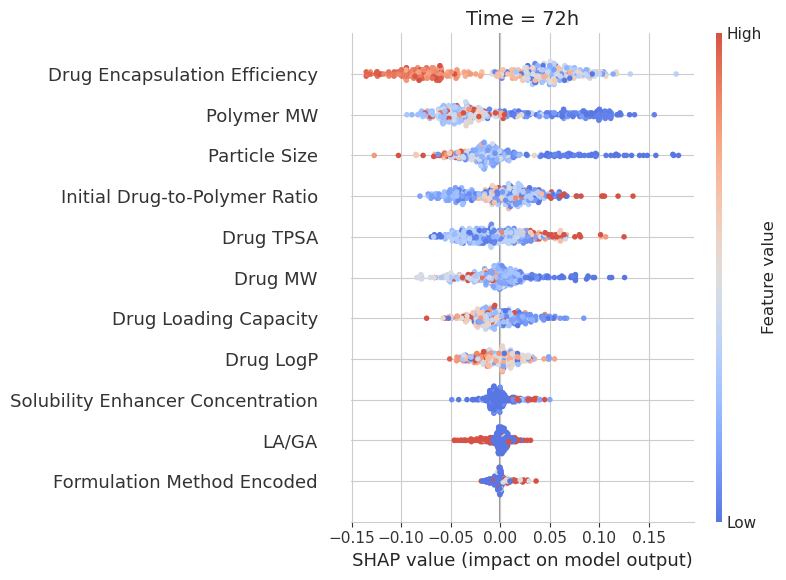

In [25]:
feature_names = formulation_df.drop(columns=['Formulation Index']).columns.tolist()
all_X_test = np.vstack(stored_shap_test_sets)

# --- Create a lighter red-to-blue colormap ---
base_cmap = cm.get_cmap("coolwarm")  # red-to-blue
light_cmap = LinearSegmentedColormap.from_list(
    "light_coolwarm",
    base_cmap(np.linspace(0.1, 0.9, 256))  # cut off the darkest colors
)


# Restructure: stored_shap_values is list of [shap_output_0, shap_output_1, shap_output_2] per fold
n_outputs = len(interp_time_points)

for i, t in enumerate(interp_time_points):
    # Collect shap values for output i across all folds
    shap_for_output_i = np.vstack([fold_shap[i] for fold_shap in stored_shap_values])
    
    plt.figure()
    shap.summary_plot(shap_for_output_i, all_X_test, feature_names=feature_names, show=False, 
    cmap=light_cmap)
    plt.title(f"Time = {t*24}h", fontsize=14)
    plt.tight_layout()
    plt.show()

In [28]:
# Storage per timepoint
rmse_per_timepoint = {t: [] for t in interp_time_points}
corr_per_timepoint = {t: [] for t in interp_time_points}
pval_per_timepoint = {t: [] for t in interp_time_points}  # NEW
adj_r2_per_timepoint = {t: [] for t in interp_time_points}
p = X.shape[1]

for preds, targets in zip(stored_best_preds, stored_test_targets):
    n = len(targets)
    for i, t in enumerate(interp_time_points):
        rmse_t = np.sqrt(mean_squared_error(targets[:, i], preds[:, i]))
        rmse_per_timepoint[t].append(rmse_t)
        
        corr_t, pval_t = pearsonr(targets[:, i], preds[:, i])  # capture p-value
        corr_per_timepoint[t].append(corr_t)
        pval_per_timepoint[t].append(pval_t)  # NEW
        
        r2_t = r2_score(targets[:, i], preds[:, i])
        adj_r2_t = 1 - (1 - r2_t) * (n - 1) / (n - p - 1)
        adj_r2_per_timepoint[t].append(adj_r2_t)

# Print summary
print(f"{'Time':<10} {'RMSE':<20} {'Correlation (p-val)':<25} {'Adj R2':<20}")
print("=" * 75)
for t in interp_time_points:
    rmse_mean, rmse_std = np.mean(rmse_per_timepoint[t]), np.std(rmse_per_timepoint[t])
    corr_mean = np.mean(corr_per_timepoint[t])
    pval_mean = np.mean(pval_per_timepoint[t])  # or use median for p-values
    adj_r2_mean, adj_r2_std = np.mean(adj_r2_per_timepoint[t]), np.std(adj_r2_per_timepoint[t])
    print(f"{t}h{'':<8} {rmse_mean:.4f} ± {rmse_std:.4f}    {corr_mean:.4f} (p={pval_mean:.2e})    {adj_r2_mean:.4f} ± {adj_r2_std:.4f}")

Time       RMSE                 Correlation (p-val)       Adj R2              
1h         0.1484 ± 0.0289    0.6344 (p=2.67e-03)    0.0522 ± 0.2645
2h         0.1697 ± 0.0276    0.6518 (p=2.91e-04)    0.0891 ± 0.1923
3h         0.1810 ± 0.0257    0.6745 (p=9.37e-05)    0.1140 ± 0.1531
